In [ ]:
# import h5py
# import pandas as pd
# import numpy as np

# # Step 1: Load the data matrix and metadata from the .gctx file
# gctx_file = "../data/raw/level3_beta_ctl_n188708x12328.gctx"
# h5_file = "../data/raw/compound_control_dataset_all.h5"

# chunk_size = 10000  # Number of rows to process at a time

# with h5py.File(gctx_file, "r") as f:
#     # Access data matrix and metadata
#     data = f["/0/DATA/0/matrix"]
#     row_ids = f["/0/META/COL/id"][:].astype(str)  # All sample IDs (rows)
#     col_ids = f["/0/META/ROW/id"][:].astype(int)  # All gene IDs (columns)

#     # Load metadata files
#     gene_metadata = pd.read_csv("../data/raw/geneinfo_beta.txt", sep="\t")
#     pert_info = pd.read_csv("../data/raw/instinfo_beta.txt", sep="\t")

#     # Filter perturbation metadata
#     filtered_pert_info = pert_info[
#         (pert_info["qc_pass"] == 1.0) & (pert_info["pert_type"] == "ctl_vehicle")
#     ].copy()
#     filtered_pert_info.set_index("sample_id", inplace=True)

#     # Filter valid sample IDs
#     valid_sample_ids = pd.Index(row_ids).intersection(filtered_pert_info.index)
#     filtered_pert_info = filtered_pert_info.loc[valid_sample_ids]
#     filtered_pert_info.sort_index(inplace=True)

#     # Create a mapping of sample IDs to row indices
#     row_idx_map = {rid: idx for idx, rid in enumerate(row_ids)}

#     # Compute row indices for valid samples
#     filtered_row_indices = [row_idx_map[sid] for sid in valid_sample_ids]

# # Step 2: Write the filtered data matrix and metadata in chunks
# with h5py.File(h5_file, "w") as h5f:
#     # Pre-allocate space for the dataset in the HDF5 file
#     data_shape = (len(filtered_row_indices), len(col_ids))
#     data_dset = h5f.create_dataset(
#         "data", shape=data_shape, dtype="float32", compression="gzip"
#     )

#     # Write row (sample) metadata
#     for column in filtered_pert_info.columns:
#         h5f.create_dataset(
#             f"row_metadata/{column}",
#             data=filtered_pert_info[column].values.astype("S"),
#         )

#     # Write column (gene) metadata
#     for column in gene_metadata.columns:
#         h5f.create_dataset(
#             f"col_metadata/{column}",
#             data=gene_metadata[column].values.astype("S"),
#         )

#     # Write row and column IDs
#     h5f.create_dataset("row_ids", data=valid_sample_ids.values.astype("S"))
#     gene_mapping = gene_metadata.set_index("gene_id")["gene_symbol"].to_dict()
#     filtered_col_symbols = [gene_mapping.get(gid, f"Gene_{gid}") for gid in col_ids]
#     h5f.create_dataset(
#         "col_ids", data=[x.encode("utf-8") for x in filtered_col_symbols]
#     )

#     # Process and write data in chunks
#     for i in range(0, len(filtered_row_indices), chunk_size):
#         chunk_indices = filtered_row_indices[i : i + chunk_size]  # Current chunk
#         chunk_data = data[chunk_indices, :]  # Load chunk from the data matrix
#         data_dset[i : i + len(chunk_indices), :] = chunk_data  # Write to dataset

# print(f"Filtered data and metadata successfully written to {h5_file}.")

In [ ]:
# import h5py
# import pandas as pd

# # Step 1: Load the data matrix and metadata from the .gctx file
# gctx_file = "../data/raw/level3_beta_ctl_n188708x12328.gctx"

# with h5py.File(gctx_file, "r") as f:
#     # Access the entire data matrix and metadata
#     data = f["/0/DATA/0/matrix"]
#     row_ids = f["/0/META/COL/id"][:].astype(str)  # Sample IDs (rows)
#     col_ids = f["/0/META/ROW/id"][:].astype(int)  # Gene IDs (columns)

#     # Load metadata files
#     gene_metadata = pd.read_csv("../data/raw/geneinfo_beta.txt", sep="\t")
#     pert_info = pd.read_csv("../data/raw/instinfo_beta.txt", sep="\t")

#     # Filter perturbation metadata
#     filtered_pert_info = pert_info[
#         (pert_info["qc_pass"] == 1.0) & (pert_info["pert_type"] == "ctl_vehicle")
#     ].copy()
#     filtered_pert_info.set_index("sample_id", inplace=True)

#     # STEP A: Reduce filtered_pert_info to match row_ids
#     subset_row_ids = pd.Index(row_ids)
#     subset_row_ids = subset_row_ids.intersection(filtered_pert_info.index)
#     subset_pert_info = filtered_pert_info.loc[subset_row_ids].copy()
#     subset_pert_info.sort_index(inplace=True)

#     # Keep a separate column for sample_id (while retaining it as index)
#     subset_pert_info["sample_id"] = subset_pert_info.index

#     # STEP B: Recompute the row indices in the data matrix for valid sample_ids
#     row_idx_map = {rid: idx for idx, rid in enumerate(row_ids)}
#     filtered_row_indices = [row_idx_map[sid] for sid in subset_pert_info.index]

#     # Filter the data matrix to match the final subset of row indices
#     filtered_data_matrix = data[filtered_row_indices, :]

# # Step 2: Map gene IDs to gene symbols
# gene_mapping = gene_metadata.set_index("gene_id")["gene_symbol"].to_dict()
# filtered_col_symbols = [gene_mapping.get(gid, f"Gene_{gid}") for gid in col_ids]

# # Step 3: Write the filtered data and metadata to an HDF5 file
# h5_file = "../data/raw/compound_control_dataset.h5"

# with h5py.File(h5_file, "w") as h5f:
#     # Write the filtered data matrix
#     h5f.create_dataset("data", data=filtered_data_matrix, compression="gzip")

#     # Write row (sample) metadata
#     for column in subset_pert_info.columns:
#         h5f.create_dataset(
#             f"row_metadata/{column}",
#             data=subset_pert_info[column].values.astype("S"),
#         )

#     # Write column (gene) metadata
#     for column in gene_metadata.columns:
#         h5f.create_dataset(
#             f"col_metadata/{column}",
#             data=gene_metadata[column].values.astype("S"),
#         )

#     # Write final row and column IDs
#     h5f.create_dataset("row_ids", data=subset_pert_info.index.values.astype("S"))
#     h5f.create_dataset(
#         "col_ids", data=[x.encode("utf-8") for x in filtered_col_symbols]
#     )

# print(f"Filtered data and metadata successfully written to {h5_file}.")

In [7]:
# h5_file = "../data/raw/compound_control_dataset.h5"
# with h5py.File(h5_file, "r") as h5f:
#     # Load the data matrix
#     data_matrix = h5f["data"][:]

#     # Decode row metadata
#     row_metadata = {
#         key: h5f[f"row_metadata/{key}"][:].astype(str) for key in h5f["row_metadata"]
#     }

#     # Decode column metadata
#     col_metadata = {
#         key: h5f[f"col_metadata/{key}"][:].astype(str) for key in h5f["col_metadata"]
#     }

#     # Load and decode row and column IDs
#     row_ids = h5f["row_ids"][:].astype(str)
#     col_ids = h5f["col_ids"][:].astype(str)

# # Convert metadata to DataFrames for ease of use (optional)
# import pandas as pd

# row_metadata_df = pd.DataFrame(row_metadata)
# col_metadata_df = pd.DataFrame(col_metadata)


In [ ]:
# Add src to path
import sys
import os

from utils import create_smiles_dict

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join("..", "src")))

from torch.utils.data import  DataLoader, random_split
from data_sets import PerturbationDataset
import pandas as pd

# 1) Create the dataset as you showed
controls = "../data/raw/compound_control_dataset.h5"
perturbations = "../data/raw/compound_pertubation_dataset.h5"

# Load the data
smiles_df = pd.read_csv("../data/raw/compoundinfo_beta.txt", sep="\t")

smiles_dict = create_smiles_dict(smiles_df)

dataset = PerturbationDataset(
    controls_file=controls,
    perturbations_file=perturbations,
    smiles_dict=smiles_dict,
    plate_column="det_plate",
    normalize=True,
    n_rows=10000,
    pairing="random",
    landmark_only=True,
)

print(f"Full Dataset has {len(dataset)} (control, pert) pairs.")

# Suppose you want 70% train, 15% val, 15% test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_len = len(dataset)
train_size = int(train_ratio * total_len)
val_size = int(val_ratio * total_len)
test_size = total_len - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

print(
    f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}"
)

C:\Users\20191678\AppData\Local\Temp/ipykernel_22820/1540577773.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smiles_df["canonical_smiles"] = smiles_df["canonical_smiles"].fillna("Unknown")
2024-12-24 14:37:09 [INFO] - The smiles_dict is valid.


Full Dataset has 9970 (control, pert) pairs.
Train: 6979, Val: 1495, Test: 1496


In [ ]:
batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

# Example iteration
for batch in train_loader:
    features = batch["features"]
    labels = batch["labels"]
    meta = batch["metadata"]
    print("Features Shape:", features.shape)  # (batch_size, num_genes)
    print("Labels Shape:", labels.shape)  # (batch_size, num_genes)
    print("Metadata sample:", meta["control_metadata"], meta["pert_metadata"])
    break

Features Shape: torch.Size([256, 978])
Labels Shape: torch.Size([256, 978])
Metadata sample: {'bead_batch': ['b34', 'b35', 'b35', 'b35', 'b32', 'b34', 'b34', 'b32', 'b35', 'b34', 'b35', 'b7', 'b38', 'b32', 'b34', 'b34', 'b35', 'b34', 'b7', 'b34', 'b35', 'b34', 'b34', 'b35', 'b7', 'b32', 'b32', 'b7', 'b35', 'b40', 'b17', 'b34', 'b32', 'b32', 'b32', 'b32', 'f1b10', 'b34', 'b32', 'b35', 'b41', 'b32', 'b32', 'b34', 'b11', 'b35', 'b32', 'b34', 'f1b10', 'b35', 'b32', 'b33', 'b32', 'b32', 'b32', 'b34', 'b35', 'b34', 'b34', 'f1b10', 'b35', 'b40', 'b15', 'b34', 'f1b10', 'b35', 'b41', 'b33', 'b35', 'b34', 'b34', 'b34', 'b34', 'b35', 'b34', 'b34', 'b35', 'b34', 'b32', 'b35', 'b41', 'b32', 'b32', 'b34', 'b34', 'b34', 'f1b10', 'b35', 'b35', 'f1b10', 'b34', 'b34', 'b32', 'b7', 'b35', 'b7', 'b34', 'b35', 'b32', 'b35', 'b35', 'b35', 'b34', 'b32', 'b32', 'b7', 'b32', 'b32', 'b35', 'b40', 'b41', 'b34', 'b35', 'b34', 'b41', 'b33', 'b35', 'b32', 'b34', 'b7', 'b34', 'b35', 'b7', 'b34', 'b34', 'b34', 'b41',

In [14]:
from training import train_multimodal_model
from perturbinator import Perturbinator
import torch


model = Perturbinator(gene_dim=978)

# Criterion and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3
)

device = "cuda" if torch.cuda.is_available() else "cpu"
train_losses, val_losses = train_multimodal_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=20,
    device=device,
    gradient_clipping=1.0,
    early_stopping_patience=5,
    model_name="Perturbinator",
    use_mixed_precision=True,
)

print("Training complete. Best model restored. Final train and val losses:")
print("Train:", train_losses)
print("Val:", val_losses)

100%|██████████| 20/20 [06:41<00:00, 20.06s/it]

Training complete. Best model restored. Final train and val losses:
Train: [0.016549692700069764, 0.008166698125397895, 0.0068757914106074595, 0.0062270219861344026, 0.0054876442115780666, 0.0050816484719098404, 0.004750929203574494, 0.004477025700123278, 0.004292344332952429, 0.0041017654519751095, 0.00396724991835913, 0.0038573995212954526, 0.00374611028688989, 0.0036574739089936335, 0.003606660912194249, 0.0035284621164298055, 0.0034624264374585167, 0.003404012070035638, 0.0033496196195712553, 0.00330507009383443]
Val: [0.010021236958386673, 0.007218532407484311, 0.006536131430619918, 0.005767351704035176, 0.005405511087948935, 0.005256833391744242, 0.004603691119625995, 0.004431505376015311, 0.004200348513369894, 0.004012676895303983, 0.003958891263747142, 0.00403791970163773, 0.003710430993515708, 0.0036944781085813563, 0.0035677720187350134, 0.003602503328386868, 0.003450571059668891, 0.0034336156560774915, 0.0033468719444632307, 0.0033723535235848246]


In [15]:
# After training:
from evaluation import evaluate_model


print("Training complete. Best model restored. Final train and val losses:")
print("Train:", train_losses)
print("Val:", val_losses)

# Evaluate on test set
test_metrics = evaluate_model(model, test_loader,criterion=criterion, device=device)
print("Test MSE:", test_metrics["MSE"])
print("Test R^2:", test_metrics["R2"])
print("Test Pearson correlation:", test_metrics["PCC"])

Training complete. Best model restored. Final train and val losses:
Train: [0.016549692700069764, 0.008166698125397895, 0.0068757914106074595, 0.0062270219861344026, 0.0054876442115780666, 0.0050816484719098404, 0.004750929203574494, 0.004477025700123278, 0.004292344332952429, 0.0041017654519751095, 0.00396724991835913, 0.0038573995212954526, 0.00374611028688989, 0.0036574739089936335, 0.003606660912194249, 0.0035284621164298055, 0.0034624264374585167, 0.003404012070035638, 0.0033496196195712553, 0.00330507009383443]
Val: [0.010021236958386673, 0.007218532407484311, 0.006536131430619918, 0.005767351704035176, 0.005405511087948935, 0.005256833391744242, 0.004603691119625995, 0.004431505376015311, 0.004200348513369894, 0.004012676895303983, 0.003958891263747142, 0.00403791970163773, 0.003710430993515708, 0.0036944781085813563, 0.0035677720187350134, 0.003602503328386868, 0.003450571059668891, 0.0034336156560774915, 0.0033468719444632307, 0.0033723535235848246]
Test MSE: 0.003303232420094

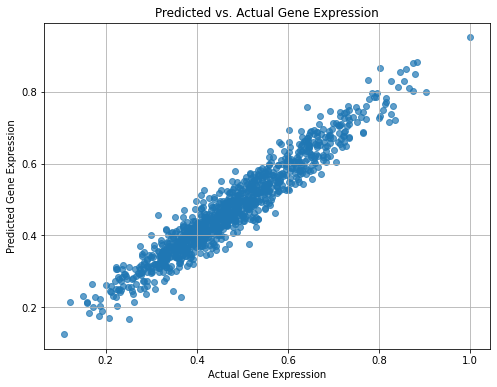

0.3937801 0.40265942


In [48]:
# Get some predictions from the test set
import numpy as np

model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        features = batch_data["features"].to(device)
        labels = batch_data["labels"].to(device)
        smiles_list = batch_data["smiles"]

        # Forward pass
        preds = model(features, smiles_list)  # shape (B, #genes)

        # Move to CPU for easy concatenation
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        break

# Select a random sample
sample_idx = np.random.randint(0, len(preds))
sample_pred = preds[sample_idx]
sample_label = labels[sample_idx]

# Plot the predicted vs. actual gene expression
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_label, sample_pred, alpha=0.7)
plt.xlabel("Actual Gene Expression")
plt.ylabel("Predicted Gene Expression")
plt.title("Predicted vs. Actual Gene Expression")
plt.grid(True)
plt.show()

print(sample_pred[0], sample_label[0])